In [11]:
# macro do ipython para rederizar o matplotlib inline
%matplotlib inline

# numpy é uma biblioteca de python que 
# nos permite fazer operações matriciais e vetoriais
# facilmente, e eficientemente (até um certo tamanho)
import numpy as np

import matplotlib.pyplot as plt

### Objetivo

O objetivo desse jupyter notebook é complementar a aula teórica com uma perspectiva prática do assunto.
Vamos implementar o método dos mínimos quadrados em numpy para ficarmos mais familiares com a biblioteca, além disso vamos utilizar algumas implementações da biblioteca scikit-learn. A ideia é mostrar como alguns métodos do scikit-learn funciona por de baixo dos panos, além de nos familiarizarmos mais com esssa ferramenta.

In [12]:
class RegressaoLinear(object):

    def __init__(self):
        self.w_ = None
    
    def ajustar(self, X, y):
        return self
    
    def predizer(self, X):
        if self.w_ is None:
            raise ValueError('Tentando predizer sem ajustar aos dados!!!') 
            
        n_exemplos, n_atributos = X.shape
        
        # expandimos X acrescentando uma coluna de 1's
        # para o w_0 que representa onde o hiperplano
        # corta o eixo y
        X = np.hstack((np.ones((n_exemplos, 1)), X))
            
        return X.dot(self.w_)


Esse é o esqueleto de nossa classe que ajustas os dados usando um regressão linear. Todo método de regressão faz sua predição do modo descrito no método **predizer**, ou seja, $X . w$. Porém cada um deles há uma forma distinta de aprender os pesos $w_0, ..., w_m$. 

Vamos então implementar o método para ajustar aos dados (encontrar o w) utilizando o método dos mínimos quadrados visto em aula.

Lembra-se que há uma fórmula analítica para resolvermos o problema de minimzação da soma dos quadrados das diferenças $\min_{w} ||Xw - y||^2_2$ que é definida do seguinte modo:

$w = (X^TX)^{-1}X^Ty$

Como vamos implementar isso? Vou ter de fazer todos essas operações matriciais? Vou ter de implementar um algoritmo para calcular a inversa de uma matriz?

É aí que entra o numpy! Ele nos oferece todas essas operações implementadas eficientemente em python (por de baixo dos panos são implementados em C, mas com um interface para python) para possamos fazer chamadas bem alto nível e consigamos implementar o método dos mínimos quadrados sem muito esforço.

Então como que fica isso em python + numpy?

In [13]:
class RegressaoLinearMMQ(RegressaoLinear):
    
    def ajustar(self, X, y):
        n_exemplos, n_atributos = X.shape
        
        if y.ndim == 1:
            y = y[:, np.newaxis]
        
        # expandimos X acrescentando uma coluna de 1's
        # para o w_0 que representa onde o hiperplano
        # corta o eixo y
        X = np.hstack((np.ones((n_exemplos, 1)), X))
        
        self.w_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return self

Isso mesmo, simples assim! 

O grosso da computação está np trecho a seguir, que é a tradução da fórmula $w = (X^TX)^{-1}X^Ty$ para python com numpy.

```python
    self.w_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
```
O numpy tem um módulo linalg (linear algebra), com várias funções de algebra linear, tais como inversada matriz, determinante, auto valores, só para citar algumas. Além disso, em numpy é usado a função dot para se fazer multiplicação de matrizes e também para fazer produto interno entre dois vetores.

Vamos só explicar algumas cosinhas que podem parecer estranhas no primeiro momento.

```python
if y.ndim == 1:
    y = y[:, np.newaxis]
```

O trecho de código acima garante que $y$ seja um vetor no formato $Nx1$, ou seja, colunar.

Para explicar o trecho a seguir precisamos recapitular umas cosinhas da aula.

```python
# expandimos X acrescentando uma coluna de 1's
# para o w_0 que representa onde o hiperplano
# corta o eixo y
X = np.hstack((np.ones((n_exemplos, 1)), X))
```

Lembram-se que nós temos $n\_atributos + 1$ pesos, onde o primeiro peso o $w_0$ é a interseção da reta com o eixo $y$? Lembram-se que a fórmula genérica para nossos modelos lineares é $y = w_0 * 1 + w_1 * x_1 + ... + w_m * x_m$?

Desse modo, para achar o peso $w_0$ precisamos acrescentar uma variável "arficial" que sempre vai ter o valor 1.
Portanto, é para isso que serve o código acima, para acrescentar essa variável e nos permitir achar o $w_0$!

### Testando nossa implementação

Vamos testar nossa implementação em um conjunto de dados. Para isso vamos utilizar um banco de dados disponibilizado pela biblioteca de aprendizado de máquinas scikit-learn.

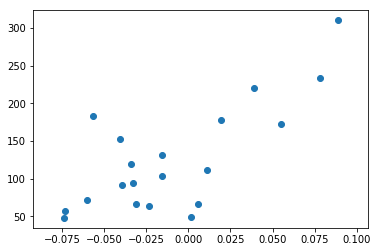

In [14]:
from sklearn import datasets, linear_model

# Carregando o cojunto de dados sobre diabetes
diabetes = datasets.load_diabetes()

# Vamos utilizar apenas um atributo para facilitar nossa visualização
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Vamos pegar apenas umas 20 amostras
X_amostra = diabetes_X[-20:]
y_amostra = diabetes.target[-20:]

plt.scatter(X_amostra, y_amostra)

Bora treinar nosso modelo com nossa implementação :)

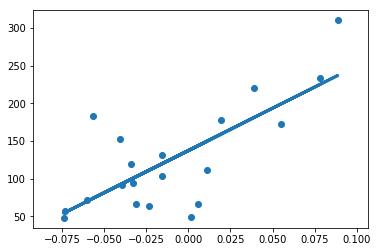

In [15]:
reg = RegressaoLinearMMQ()
reg.ajustar(X_amostra, y_amostra)

plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

Olha gente que lindo! Nossa regressão linear funcionou. Vamos contrastar nossa implementação com o do scikit-learn.

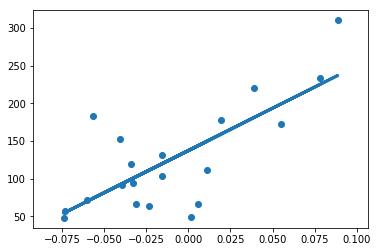

In [16]:
reg = linear_model.LinearRegression()
reg.fit(X_amostra, y_amostra)

plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predict(X_amostra),
         linewidth=3)

Obtivemos o mesmo resultado! Quem precisa de scikit-learn agora?? Bricadeira...

Vamos acrescentar um outlier nesse conjunto de dados e verificar como esse método se comporta.

## Sensibilidade a Outliers

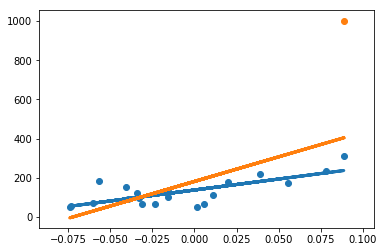

In [17]:
order = np.argsort(X_amostra, 0).ravel()

# vamos adicionar um exemplo com y muito discrepande
# e x igual ao maior valor do conjunto de dados
X_outlier = np.vstack((X_amostra, [[X_amostra.max()]]))
y_outlier = np.concatenate((y_amostra, [1000]))


reg = RegressaoLinearMMQ()

reg.ajustar(X_amostra, y_amostra)
# traçando os pontos e reta anterior
plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

reg.ajustar(X_outlier, y_outlier)
# traçando o outlier e a nova reta
plt.scatter(X_outlier[-1:], y_outlier[-1:])
plt.plot(X_outlier, reg.predizer(X_outlier),
         linewidth=3)

## Lasso

Para o Lasso, não uma formula análitica para encontrar os pesos $w$. Desse modo, vamos brincar um pouco com ele utilizando a implementação do scikit-learn.

Brinque um pouco com parâmetro **alpha** do Lasso. A medida que você vai aumentando seu valor, maior é o impacto da penalização do regularizador na otimização dos pesos.

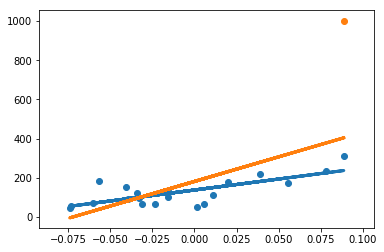

In [18]:
lasso = linear_model.Lasso(alpha=0.001)

reg.ajustar(X_amostra, y_amostra)
# traçando os pontos e reta anterior
plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

lasso.fit(X_outlier, y_outlier)
# traçando o outlier e a nova reta
plt.scatter(X_outlier[-1:], y_outlier[-1:])
plt.plot(X_outlier, lasso.predict(X_outlier),
         linewidth=3)

## Ridge Regression

No caso do ridge regression há uma fórmula fechada para se encontrar $w$. 

Essa fórmula é a seguinte:

$w = (X^TX + I\alpha)^{-1}X^Ty$

Portanto, para que você se familiarize um pouco com numpy peço que faça o seguinte exercício. Você deve completar o método **ajustar** da classe ***RegressaoLinearRidge*** abaixo com a implementação em numpy da equação anterior. Após completar sua implementação, brinque um pouco com os valores de alpha e verifique como a modelo se comporta.

In [43]:
class RegressaoLinearRidge(RegressaoLinear):
    def __init__(self, alpha = 1):
        super(RegressaoLinearRidge, self).__init__()
        self.alpha_ = alpha
    
    def ajustar(self, X, y):
        # complete com sua implementação utilizando numpy
        return self

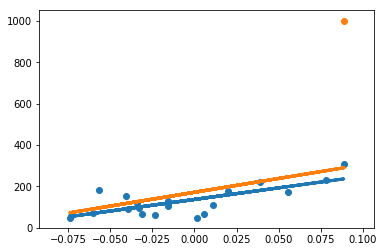

In [42]:
reg = RegressaoLinearMMQ()
reg.ajustar(X_amostra, y_amostra)
# traçando os pontos e reta anterior
plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

ridge = RegressaoLinearRidge(alpha=0.04)
ridge.ajustar(X_outlier, y_outlier)
# traçando o outlier e a nova reta
plt.scatter(X_outlier[-1:], y_outlier[-1:])
plt.plot(X_outlier, ridge.predizer(X_outlier),
         linewidth=3)